In [25]:
import numpy as np 
import pandas as pd
from src import utils, redcells, fig1
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import clear_output
from pathlib import Path
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:
ROOT_PATH = "Z:/data/PROC"
RET_PATH = "D:/retinotopy/aligned_xy/behav"
MDL_PATH = "C:/Users/labadmin/Documents/category-neural/data" # we don't have models there, so it will create a new one.

In [50]:
#VG21 = []
#VG21.append({'mname': 'VG21', 'datexp': '2025_06_24', 'blk':'3','session': 'all rewarded before'})
#VG21.append({'mname': 'VG21', 'datexp': '2025_06_25', 'blk':'2','session': 'first training'})
#VG21.append({'mname': 'VG21', 'datexp': '2025_07_17', 'blk':'3','session': 'last training'})
#VG21.append({'mname': 'VG21', 'datexp': '2025_07_18', 'blk':'2','session': 'all rewarded after'})
VG24 = []
VG24.append({'mname': 'VG24', 'datexp': '2025_06_25', 'blk':'2','session': 'all rewarded before'})
VG24.append({'mname': 'VG24', 'datexp': '2025_06_26', 'blk':'2','session': 'first training'})
VG24.append({'mname': 'VG24', 'datexp': '2025_07_10', 'blk':'2','session': 'last training'})
VG24.append({'mname': 'VG24', 'datexp': '2025_07_14', 'blk':'2','session': 'all rewarded after'})
dbase = pd.DataFrame(VG24) # mouse to add
dbase

,mname,datexp,blk,session
0,VG24,2025_06_25,2,all rewarded before
1,VG24,2025_06_26,2,first training
2,VG24,2025_07_10,2,last training
3,VG24,2025_07_14,2,all rewarded after


In [52]:
for i, row in dbase.iterrows():
    name, date, blk = row['mname'], row["datexp"], row["blk"]
    m1 = utils.load_mouse(name, date, blk, load_neurons=True, interp_behav=True, load_retinotopy=True, 
                        data_path=ROOT_PATH, ret_path=RET_PATH,  mdl_path=MDL_PATH, opt_tlag = 1)
    frameselector = utils.get_frameselector(m1)
    istim_df = pd.DataFrame(m1._timeline['istim'], columns=['istim'])
    istim_df["trial_no"] = np.arange(0, len(istim_df)).astype(float)
    m1.frameselector = (frameselector.reset_index()
        .rename(columns = {'index':'frame'})
        .merge(istim_df, left_on='trial_no', right_on='trial_no', how='left')
        .set_index('frame'))

    green_channel = Path(ROOT_PATH).joinpath(name, date, blk, "suite2p")
    m1.isred = redcells.get_redcells(green_channel) # the corrected redcells.npy
    # lets filter out cells with low snr
    m1.isred = m1.isred[m1._snr>=.25]
    m1._spks = m1._spks[m1._snr>=.25]
    m1._xpos = m1._xpos[m1._snr>=.25]
    m1._ypos = m1._ypos[m1._snr>=.25]
    m1._iplane = m1._iplane[m1._snr>=.25]
    m1.iarea = m1.iarea[m1._snr>=.25]
    m1.iregion = m1.iregion[m1._snr>=.25]
    m1.xy_t = m1.xy_t[m1._snr>=.25]
    m1._snr = m1._snr[m1._snr>=.25]
    m1.trial_dict = utils.get_trialno_bytype(m1.frameselector) #trial_no dict
    # lets get the interpolated spks
    for zscored in [True, False]:
        print("saving zscored version" if zscored else "saving not zscored version") 
        m1.interp_spks = utils.interp_spks_by_corridorlength(m1, m1.frameselector, z = zscored, corridor_length=400)
        save_path = r"D:\mouseobj" if zscored else r"D:\mouseobj\notz"
        utils.compute_dprime(m1, discrimination_region = (0,100), corridor_length = 400, nogray = False)
        utils.save_mouse(m1, compressed=False, mdl_path=save_path)
    clear_output(wait=True)

Checking if model object exists ...
Timeline with fname: Timeline_VG24_2025_07_14_2.mat not found, trying with fname: VG24_2025_07_14_2.mat 
Timeline file is in v7.3 format, loading with h5py
planes: 20


100%|██████████| 20/20 [01:52<00:00,  5.61s/it]


Loading retinotopy data from D:\retinotopy\aligned_xy\behav\VG24_2025_07_14_2_behav.npz
(7186, 2)
saving zscored version
36 11662
interpolating 6411 neurons, 11627 frames to
the vector of distance with shape: (11627,)
neurons: 6411, trials: 327, corridor length: 400
dprime saved in MouseObject.train_dp (neurons) using even trials
Creating directory D:\mouseobj\VG24\2025_07_14\2
Mouse object saved to D:\mouseobj\VG24\2025_07_14\2
saving not zscored version
36 11662
interpolating 6411 neurons, 11627 frames to
the vector of distance with shape: (11627,)
neurons: 6411, trials: 327, corridor length: 400
dprime saved in MouseObject.train_dp (neurons) using even trials
Creating directory D:\mouseobj\notz\VG24\2025_07_14\2
Mouse object saved to D:\mouseobj\notz\VG24\2025_07_14\2


In [53]:
areas = ["V1", "medial", "lateral", "anterior"]
ctypes = ["exc", "inh"]
corridor_length = 400
main_dir = Path(f"../data/overall")

def select_neurons(m1, area: str, celltype:str, dprime = None, dptsh=95):
    ia = utils.get_region_idx(m1.iarea, area)
    assert celltype in ['exc', 'inh'], "celltype must be either 'exc' or 'inh'"
    selected_type = np.logical_not(m1.isred[:,0]).astype(bool) if celltype == 'exc' else m1.isred[:,0].astype(bool)
    if dprime is None:
        pstv_tsh, ngtv_tsh = utils.get_dp_thresholds(m1.train_dp[ia*selected_type], tsh=dptsh) #tresh based on the area
    else:
        pstv_tsh, ngtv_tsh = utils.get_dp_thresholds(dprime[ia*selected_type], tsh=dptsh)
    prefer_r = (m1.train_dp>=pstv_tsh)
    prefer_nr = (m1.train_dp<=ngtv_tsh)
    area_prefer_r = prefer_r * ia * selected_type
    area_prefer_nr = prefer_nr * ia * selected_type
    return area_prefer_r, area_prefer_nr, selected_type, ia

In [54]:
session_types = dbase["session"].unique()
session_folder_names = ["all_first", "first_training", "last_training", "all_last"]
main_dir = Path(f"../data/overall")
for iss, session in enumerate(session_types):
    print(f"Processing session {iss+1}/{len(session_types)}: {session}")
    dbase_session = dbase.query(f"session == '{session}'")
    dbase_session = dbase_session.reset_index(drop=True)
    cds = np.empty((dbase_session.shape[0], 4, len(areas), len(ctypes), corridor_length)) # mice, ttype, areas, cell types, positions
    for im, row in dbase_session.iterrows():
        name, date, blk = row['mname'], row["datexp"], row["blk"]
        m = utils.load_mouse(name, date, blk, load_neurons=True, interp_behav=True, load_retinotopy=True, mdl_path=r"D:\mouseobj")
        protA = m.trial_dict["rewarded"][1::2]
        protB = m.trial_dict["non rewarded"][1::2]
        restA = m.trial_dict["rewarded test"]
        restB =  m.trial_dict["non rewarded test"]
        ## Dprime selection trials
        trial_split = {"rewarded": protA, "non rewarded": protB, "rewarded test": restA, "non rewarded test": restB}
        for ia, area in enumerate(["V1", "medial", "lateral", "anterior"]):
            for ct, c_type in enumerate(["exc", "inh"]):
                a_prefer, b_prefer, _ , _ = select_neurons(m, area, c_type)
                cd = m.interp_spks[a_prefer].mean(0) - m.interp_spks[b_prefer].mean(0)
                for it, trials in enumerate(trial_split.values()):
                    cds[im, it, ia, ct] = cd[trials,:].mean(0)
    # if a folder for the session does not exist, create it, and stack the cds to the previous ones
    session_dir = main_dir / session_folder_names[iss]
    if not session_dir.exists():
        session_dir.mkdir(parents=True)
    previous_cds = np.load(main_dir.joinpath(session_folder_names[iss], "cod_dirs_0_100_updated.npy"), allow_pickle=True)
    cds_stacked = np.vstack((previous_cds, cds))
    np.save(session_dir/"cod_dirs_0_100_updated.npy", cds_stacked)
    clear_output(wait=True)

Processing session 4/4: all rewarded after
Checking if model object exists ...
Loading mouse object from D:\mouseobj\VG24\2025_07_14\2
Existing mouse object has the following attributes:
dict_keys(['name', 'datexp', 'blk', 'data_path', '_timeline', '_data_var', '_settings', '_timestamps', '_trial_info', '_spks', '_ypos', '_xpos', '_iplane', '_stat', '_ops', '_snr', 'xy_t', 'iarea', 'iregion', 'outline', 'frameselector', 'isred', 'trial_dict', 'interp_spks', 'train_dp'])


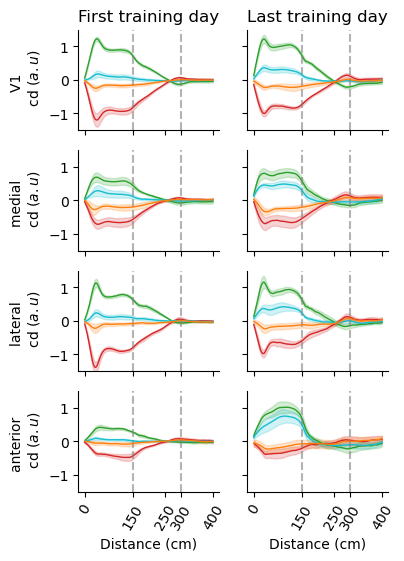

In [55]:
main_dir = Path(f"../data/overall")
first_day_cds = np.load(main_dir / "first_training/cod_dirs_0_100_updated.npy")
last_day_matched_cds = np.load(main_dir / "last_training/cod_dirs_0_100_updated.npy")
fig, ax = plt.subplots(4, 2, figsize=(4, 6), sharex=True, sharey=True)
for iday, day_response in enumerate([first_day_cds, last_day_matched_cds]):
    ax[-1,iday].set_xlabel('Distance (cm)')
    ax[-1,iday].set_xticks([0, 150, 250, 300, 400])
    ax[0,iday].set_title("First training day" if iday == 0 else "Last training day")
    for ttype in range(4):
        for a, area in enumerate(areas):
            fig1.plot_cds(day_response, ttype, a, 0, ax[a,iday], references=True)
            ax[a,iday].set_ylim(-1.5,1.5)
            if iday == 0:
                ax[a,iday].set_ylabel(f"{areas[a]} \n cd $(a.u)$", loc='center')
                #rotate xticks
            for tick in ax[a,iday].get_xticklabels():
                tick.set_rotation(60)
sns.despine()